<a href="https://colab.research.google.com/github/sivaa-shaanth/cs469-recommender-model/blob/main/Recommender_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [45]:
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve ("https://github.com/aravindsankar28/Recommender-Models/blob/main/ml-100k.zip?raw=true", "ml-100k.zip")
zip_ref = zipfile.ZipFile('ml-100k.zip', "r")

zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


We first load the MovieLens Data, and create DataFrames containing movies, users, and ratings.


In [46]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')


In [47]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')


In [48]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [49]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))


In [50]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens = movielens.drop(columns = ["video_release_date", "imdb_url"])

In [51]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,genre_unknown,Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,...,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,0,1,1,0,...,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,0,0,0,0,...,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,0,0,0,0,...,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,0,0,0,0,...,0,0,0,0,0,1994,49,M,writer,55105


In [52]:
def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.flatten_cols = flatten_cols

users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

users_ratings.head()


,user_id,rating count,rating mean,age,sex,occupation,zip_code
0,0,272,3.610294,24,M,technician,85711
1,1,62,3.709677,53,F,other,94043
2,2,54,2.796296,23,M,writer,32067
3,3,24,4.333333,24,M,technician,43537
4,4,175,2.874286,33,F,other,15213


### Question 1: Rating Distribution of users.
First, we look at the distribution of ratings per user to examine number of ratings and average rating per user.

Plot two histograms depicting: (a) the number of ratings per user and (b) average rating per user. (Use plt.hist with 10 bins)

What do you observe?



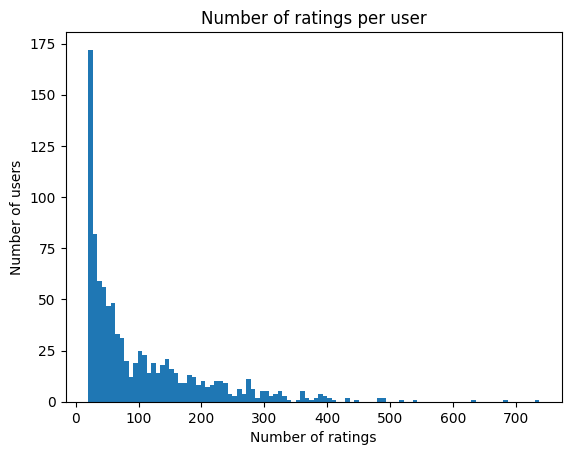

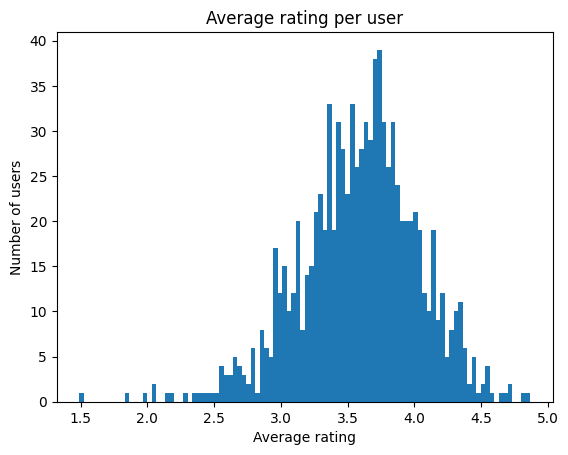

In [53]:
#plot the number of ratings per user
plt.hist(users_ratings['rating count'], bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.title('Number of ratings per user')
plt.show()

#plot the average rating per user
plt.hist(users_ratings['rating mean'], bins=100)
plt.xlabel('Average rating')
plt.ylabel('Number of users')
plt.title('Average rating per user')
plt.show()

### Question 2: Rating Distribution of movies.

Similarly, plot the rating distribution of each movie with respect to (a) the number of ratings per movie and (b) average rating per movie.


In [54]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.3):
    '''Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train_df: dataframe for training
    test_df: dataframe for testing
    '''
    eval_df = df.sample(frac=holdout_fraction, replace=False)
    
    val_df = eval_df.sample(frac=(1/3.0), replace=False)    
    test_df = eval_df[~eval_df.index.isin(val_df.index)]
    
    train_df = df[~df.index.isin(eval_df.index)]
    return train_df, val_df, test_df


In [55]:
print(len(movielens))
train, val, test = split_dataframe(movielens)
print(len(train))

100000
70000


In [56]:
# load train, val, test data for consistency.

train = pd.read_csv('ml-100k/train.csv')
val = pd.read_csv('ml-100k/val.csv')
test = pd.read_csv('ml-100k/test.csv')

print(len(train))

70000


### Item Neighborhood-based Collaborative Filtering

The code described in the next cell provides an initial implementation of neighborhood-based CF using item-based nearest neighbors. 

In [57]:
def get_pearson_correlation(item_id, j):

    #get pearsom correlation between item_id and j from the set of users who have rated both item_id and j





    #get set of users who have rated both item_id and j
    users_rated_both = set(ratings[ratings['movie_id'] == item_id]['user_id']) & set(ratings[ratings['movie_id'] == j]['user_id'])


    #for each user belonging to the set, get the rating by the user for item_id and j
    #loop through each user and get the rating for item_id and j
    ratings_item_id = []
    ratings_j = []
    total_bias_item_id = []
    total_bias_j = []
    
    numerator = []
    denominator = []

    mean = ratings['rating'].mean()
    
    for user in users_rated_both:
        curr_rating_item_id = ratings[(ratings['movie_id'] == item_id) & (ratings['user_id'] == user)]['rating'].values[0]
        ratings_item_id.append(ratings[(ratings['movie_id'] == item_id) & (ratings['user_id'] == user)]['rating'].values[0])
        curr_rating_j = ratings[(ratings['movie_id'] == j) & (ratings['user_id'] == user)]['rating'].values[0]
        ratings_j.append(ratings[(ratings['movie_id'] == j) & (ratings['user_id'] == user)]['rating'].values[0])

        numerator.append((curr_rating_item_id) * (curr_rating_j))
        denominator.append((curr_rating_item_id) ** 2 * (curr_rating_j) ** 2)

        #get the bias for each user
        #subtract the bias from the rating

        # user_bias = users_ratings[users_ratings['user_id'] == user]['rating mean'].values[0]
        # item_bias = movies[movies['movie_id'] == item_id]['rating mean'].values[0]
        # j_bias = movies[movies['movie_id'] == j]['rating mean'].values[0]

        # total_bias_item_id.append(mean + user_bias + item_bias)
        # total_bias_j.append(mean + user_bias + j_bias)

    #calculate sum of numerator
    numerator = np.sum(numerator)
    #calculate sum of denominator
    denominator = np.sqrt(np.sum(denominator))

    #calculate pearson correlation
    pearson = numerator / denominator

    print("pearson by manual calculation: ", pearson)
    return pearson
    # #calculate pearson correlation between the two items
    # pearson = np.corrcoef(ratings_item_id, ratings_j)
    # print("pearson by numpy: ", pearson)
    
    # return np.corrcoef(ratings_item_id, ratings_j)[0,1]


In [58]:
class NeighborhoodCF():

    def __init__(self, train):
        self.mu = train['rating'].mean()
        self.rating_matrix = sp.csr_matrix((train['rating'], (train['user_id'], train['movie_id']))).toarray()
        n_users, n_items = self.rating_matrix.shape[0], self.rating_matrix.shape[1]
        self.n_users, self.n_items = n_users, n_items
        
        # Compute item biases.
        self.item_bias, self.user_bias = np.zeros(n_items), np.zeros(n_users)
                
        item_bias_dict = dict(train.sort_values(['movie_id'],ascending=True).
                              groupby(['movie_id'])['rating'].apply(lambda x: sum(x)/len(x) - self.mu))
        
        for key, val in item_bias_dict.items():
            self.item_bias[key] = val

        # Compute user biases.
        user_bias_dict = train.sort_values(['user_id'],ascending=True).groupby(['user_id']).apply(self.get_user_bias)

        for key, val in user_bias_dict.items():
            self.user_bias[key] = val
        
        # Compute a dictionary to store list of items per user (and vice-versa).
        self.user_items_dict = defaultdict(lambda: [], dict(train.groupby('user_id')['movie_id'].apply(list)))
        self.item_users_dict = defaultdict(lambda : [], dict(train.groupby('movie_id')['user_id'].apply(list)))                
        
        # Compute movie-movie similarities based on genres.
        
        movie_genres = train[['movie_id'] + genre_cols].drop_duplicates().sort_values('movie_id')
        movie_genres['genre'] = movie_genres[genre_cols].values.tolist()
        movie_genres_dict = dict(movie_genres[['movie_id', 'genre']].values)

        self.movie_genres_matrix = np.zeros([n_items, len(genre_cols)])

        for key, val in movie_genres_dict.items():
            self.movie_genres_matrix[key] = val

        print("moviegenre matrix", len(self.movie_genres_matrix))   
        self.movie_similarity = cosine_similarity(self.movie_genres_matrix)
        
    def get_user_bias(self, group):    
        items = group['movie_id']
        ratings = group['rating']
        assert len(items) == len(ratings)
        result = 0.0

        for item, rating in zip(items, ratings):
            result += rating - self.item_bias[item] - self.mu

        result = result/len(items)
        return result
    

    #This function finds k similar items given the item_id (based on pearson correlation).
    def find_nearest_neighbors(self, item_id,  k=5, item_list=None, pearson=False):
        if item_list is None:
            item_list = list(range(0, self.n_items))
        
        if pearson:
            similarities = np.array([get_pearson_correlation(item_id, j) for j in item_list])
        else:
            similarities = self.movie_similarity[item_id, item_list]
                
        similar_items_indices = similarities.argsort()[::-1][:k]
        return [item_list[idx] for idx in similar_items_indices]
    
    def knn_predict(self, user, item, k=5):
        numerator, denominator = 0.0, 0.0
        neighbor_items = self.user_items_dict[user]
        assert k >=0
        neighbor_items = self.find_nearest_neighbors(item, k, neighbor_items, pearson=True)
        
        for j in neighbor_items:
            sij = self.movie_similarity[item, j] + 0.000001
            denominator += sij         
            numerator += sij * (self.rating_matrix[user][j])
                
        rui = (numerator / denominator)
        return rui
                


    # TODO: complete this function in question 4    
    def bias_predict(self, user, item):
        pass
    
    # TODO: complete this function in question 5
    def knn_bias_predict(self, user, item, k=5):
        pass
    


In [59]:
model_CF = NeighborhoodCF(train)
preds, targets = [], []
for idx, row in enumerate(test[['user_id', 'movie_id', 'rating']].values):            
    u, i, r = tuple(row)
    #pred = model_CF.knn_bias_predict(int(u), int(i), k=50)
    pred = model_CF.knn_predict(int(u), int(i), k=15)
    #pred = model_CF.bias_predict(int(u), int(i))
    
    pred = np.clip(pred, 0, 5)
    preds.append(pred)
    targets.append(r)

print ("MSE on test ratings:", torch.nn.MSELoss()(torch.tensor(preds), torch.tensor(targets)))
print ("MAE on test ratings:", torch.nn.L1Loss()(torch.tensor(preds), torch.tensor(targets)))


moviegenre matrix 1682
pearson by manual calculation:  1.060430864638069
pearson by manual calculation:  1.4984528103154495
pearson by manual calculation:  2.108590488016544
pearson by manual calculation:  2.1378173259918563
pearson by manual calculation:  2.3506656668597548
pearson by manual calculation:  1.0
pearson by manual calculation:  1.0795912380986197
pearson by manual calculation:  1.116312611302876
pearson by manual calculation:  1.3567477035949578
pearson by manual calculation:  1.8306300648455311
pearson by manual calculation:  1.0
pearson by manual calculation:  1.9639610121239315
pearson by manual calculation:  2.18055706720287
pearson by manual calculation:  2.2491828581535485
pearson by manual calculation:  1.060430864638069
pearson by manual calculation:  1.8285851561044473
pearson by manual calculation:  1.414213562373095
pearson by manual calculation:  1.1671607219845073
pearson by manual calculation:  2.146354492351533
pearson by manual calculation:  1.167160721984

KeyboardInterrupt: ignored

### Question 3: Neighborhood-based CF (impact of neighborhood size)

Run the above neighborhood-based recommender `knn_predict` for different neighborhood sizes $K = \{1, 5, 10, 50, 100\}$ and plot the variation in test MSE error with respect to $K$. 


### Question 4: Bias recommender baseline. 

Complete the `bias_predict` function within the `NeighborhoodCF` class to implement the baseline recommender using user-specific, item-specific and global bias factors. $ r_{ui} = b_u + b_i + \mu $.

How does the performance of bias prediction baseline compare with the nearest neighbor recommender in `knn_predict` ? Explain.


### Question 5: Neighborhood-based CF with bias


Complete the `knn_bias_predict` function within the `NeighborhoodCF` class to implement the nearest neighborhood  recommender using user-specific, item-specific and global bias factors. (Extend `knn_predict` with biases)

$$\hat{r}_{u,i} = b_{u,i}+ \frac{\sum_{j \in S^k(i;u)} s_{i,j} \times (r_{u,j} - b_{u,j}) }{\sum_{j \in S^k(i;u)} s_{i,j}} $$


$$ b_{u,i} =  \mu + b_u + b_i$$


How does the performance of `knn_bias_predict` compare with `knn_predict` and `bias_predict` ? Explain.

### Matrix Factorization based Collaborative Filtering

This is an implementation of Matrix Factorization using a machine learning framework PyTorch - https://pytorch.org/ with automatic gradient computation.

Instead of SGD, we use PyTorch due to better optimizers and batch-wise efficient computations.  

Unlike the neighborhood-based CF model which is non-parametric, the MF model has multiple learnable parameters (latent factors) and hyper-parameters (learning rate, number of latent factors, batch size, etc.). 

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, bias=False):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.bias = bias
        
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        if self.bias:
            self.user_bias = torch.nn.Embedding(n_users, 1)
            self.item_bias = torch.nn.Embedding(n_items, 1)
            
            self.user_bias.weight.data.fill_(0.)
            self.user_bias.weight.data.fill_(0.)
        
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
    def forward(self, user, item):
        # matrix multiplication
        if self.bias:
            return self.user_bias(user).squeeze(-1) + self.item_bias(item).squeeze(-1) + \
                (self.user_factors(user)*self.item_factors(item)).sum(-1)
        else:
            return (self.user_factors(user)*self.item_factors(item)).sum(-1)

    def predict(self, user, item):
        return self.forward(user, item)
    

In [61]:
def master_train(user_lr = 1e-3, user_batch_size = 1024, user_n_factors = 128, bias_flag = False, n_epochs = 150, debug_flag = True):
    # hyper-parameters.
    lr = user_lr
    batch_size = user_batch_size
    n_factors = user_n_factors

    model_MF = MatrixFactorization(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=bias_flag)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

    train_ratings = train[['user_id', 'movie_id', 'rating']].values
    test_ratings = test[['user_id', 'movie_id', 'rating']].values
    val_ratings = val[['user_id', 'movie_id', 'rating']].values

    def test_model(model_MF, test_ratings):
        n_batches = len(test_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("test loss: ", test_loss)
        return test_loss

    def validate_model(model_MF, val_ratings):
        n_batches = len(val_ratings) // batch_size
        preds, targets = [], []
        for b in range(n_batches):
            batch_data = val_ratings[(b* batch_size) : (b+1)* batch_size]        
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            pred = model_MF.predict(user, item).detach()
            pred = np.clip(pred, 0, 5)
            preds.append(pred)
            targets.append(batch_ratings)
        preds, targets = np.concatenate(preds), np.concatenate(targets)
        val_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
        if(debug_flag):
          print ("validation loss: ", val_loss)
        return val_loss

    train_loss_master = []
    test_loss_master = [] 
    val_loss_master = [] 

    for epoch in range(0, n_epochs):
        train_loss = 0.0
        n_batches = len(train_ratings) // batch_size
        if train_ratings % batch_size is not 0:
            n_batches += 1
        np.random.shuffle(train_ratings)
        for b in range(n_batches):
            batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
            # get user, item and rating data
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            rating = torch.FloatTensor(batch_ratings)
            optimizer.zero_grad()
            model_MF.zero_grad()
            
            # predict
            prediction = model_MF(user, item)
            loss = loss_fn(prediction, rating)

            # backpropagate
            loss.backward()

            # update weights
            optimizer.step()
            
            train_loss += loss.item()
        if(debug_flag):
          print ("epoch {}: train loss {}".format(epoch, train_loss/n_batches))
        train_loss_master.append(train_loss/n_batches)
        test_loss_master.append(test_model(model_MF, test_ratings))   
        val_loss_master.append(validate_model(model_MF, val_ratings))    

    return train_loss_master, val_loss_master, test_loss_master

<>:57: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:57: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-61-5900576e6b5b>:57: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if train_ratings % batch_size is not 0:


### Question 6: Matrix Factorization (MF) based CF (loss curves)

Run the MF model for 150 epochs (or until convergence) and plot the variation in train and test errors (MSE). What do you observe? At which epoch should we choose the best model? 


In [62]:
train_loss_master, val_loss_master, test_loss_master = master_train(debug_flag = False)

0.032835039609169954


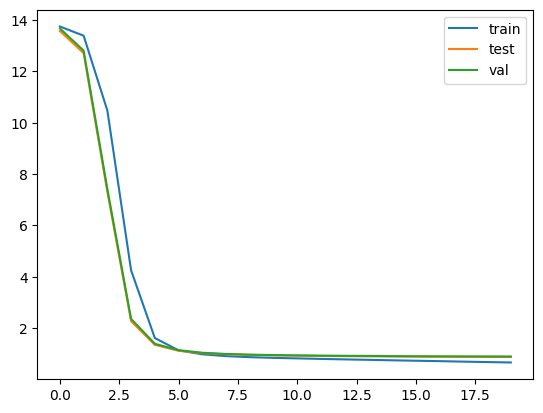

In [63]:
plt.plot(train_loss_master[0:20], label='train')
plt.plot(test_loss_master[0:20], label='test')
plt.plot(val_loss_master[0:20], label='val')
diff = [x - y for x, y in zip(val_loss_master, test_loss_master)]
print(np.mean(diff))
plt.legend()
plt.show()
#around 5-6 epochs --> test loss remains constant --> meaning we start to overfit.

### Question 7: Matrix Factorization (MF) based CF (number of latent factors)

Run the MF model for different number of latent factors $K = \{4, 16, 64, 128\}$. Plot the variation in test MSE error with respect to $K$. What do you observe? 


In [64]:
latent_factors = [4, 16, 64, 128]

test_loss_for_each_k = np.zeros((4, 150))

for i in range(len(latent_factors)):
    test_loss_for_each_k[i] = master_train(user_n_factors = latent_factors[i],  debug_flag = False)[2]

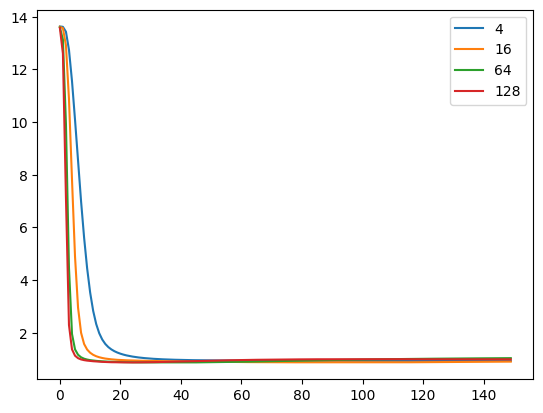

In [65]:
for i in range(len(latent_factors)):
   plt.plot(test_loss_for_each_k[i], label=latent_factors[i])
  
plt.legend()
plt.show()

### Question 8: Matrix Factorization (MF) based CF (batch size)
Model performance depends a lot of batch size and learning rate. What happens when you change the batch size from 2048? Try smaller (16, 64) and larger batch sizes (4096). 